<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/HAM10000_Interpretability_Attribution_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet torchray

In [3]:
from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchray.benchmark import get_example_data, plot_example
from torchray.utils import get_device
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [4]:
model = torch.load("/content/drive/My Drive/mHealth Privacy/Evaluating Models/Saved Models/kaggle90-best.pth", map_location=torch.device('cuda:0')) 
model.eval()
print(model)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torchvision.models.densenet.DenseNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or 

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute 

In [5]:
trans = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])

trans_color = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor()])

## Generate Masks

Image Segmentation

In [58]:
import cv2

def remove_background():
    #== Parameters =======================================================================
    BLUR = 5
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 50
    MASK_DILATE_ITER = 20
    MASK_ERODE_ITER = 20
    MASK_COLOR = (0.0,0.0,0.0) # In BGR format

    #== Processing =======================================================================
    img = cv2.imread("img1.png")
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)

    #-- Read image -----------------------------------------------------------------------
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)

    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)


    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))
    # cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1 - mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 
    cv2.imwrite('img.png', masked)
    return masked

## HAM10000 Dataset

In [6]:
import pandas as pd
import glob
import os

#make a dataset
data = pd.read_csv("/content/drive/My Drive/mHealth Privacy/Evaluating Models/Data/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

print(data)
base_skin_dir = os.path.join('/content/drive/My Drive/mHealth Privacy/Evaluating Models/Data/skin-cancer-mnist-ham10000/HAM10000_images_total')


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

data['cell_type'].value_counts()


         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


Melanocytic nevi                  6705
dermatofibroma                    1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [7]:
from PIL import Image
class dataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, transform=None):
        'Initialization'
        self.df = df
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = Image.open("/content/drive/My Drive/mHealth Privacy/Evaluating Models/Data/skin-cancer-mnist-ham10000/HAM10000_images_total/"+self.df['image_id'][index]+".jpg")
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [8]:
transform=transforms.Compose([
            transforms.Resize((224 ,224)),
            transforms.ToTensor()])

ham_data = dataset(data, transform=transform)
dataloader = DataLoader(ham_data)

## ISIC Dataset

In [9]:
transform=transforms.Compose([
            transforms.Resize((224 ,224)),
            transforms.ToTensor()])
isic_data = torchvision.datasets.ImageFolder("/content/drive/My Drive/mHealth Privacy/Evaluating Models/Data/skin-cancer-malignant-vs-benign/test", transform=transform)

## Find Masks

In [ ]:
from torchvision.utils import save_image
import os
import pandas as pd
import torchray
from torchray.benchmark import plot_example


results = []
device = get_device()
model.to(device).eval()
area = 0.1

for (x,y),z in tqdm(zip(dataloader,range(10))):  
  x = x.to(device)

  if y.item() == 2:
    # Extremal perturbation
    masks_1,_ = extremal_perturbation(
        model, x, y.item(),
        reward_func=contrastive_reward,
        perturbation="blur",
        debug=False,
        areas=[area],
        smooth=0.01,
        max_iter=800
    )
    ## Crop Important Area
    dat=torch.round(masks_1)[0].cpu().detach().numpy() # 'sharpen' mask
    true_points = np.argwhere(dat)
    if len(true_points) != 0:
      # take the smallest points and use them as the top left of your crop
      top_left = true_points.min(axis=0)
      # take the largest points and use them as the bottom right of your crop
      bottom_right = true_points.max(axis=0)
      x = x.squeeze()
      save_image(x, 'org.png')
      save_image(masks_1, 'mask.png')
      
      out = x[:,top_left[1]:bottom_right[1], 
                top_left[2]:bottom_right[2]]
      out =  torch.tensor(out, dtype=torch.float)
      save_image(out, 'img1.png')
      out = remove_background()
      save_image(torch.tensor(out).permute(2,0,1).long(), 'no_bckgrd.png')
      plt.imshow(out)

      results.append(torch.tensor(out, dtype=torch.float).permute(2,1,0))
     

## Cluster Representations

Get Representations for Clustering

In [18]:
color = []
for i in tqdm(range(len(results))):
  color.append(trans_color(results[i]).cpu().detach().numpy())
  results[i] = torch.flatten(trans(results[i]), start_dim=1).cpu().detach().numpy()

X1 = torch.flatten(torch.tensor(results), start_dim=1).cpu().detach().numpy()

In [19]:
#Sanity check
X = X1
print ("The shape of X is " + str(X.shape))

The shape of X is (67, 50176)


In [20]:
# To perform PCA we must first change the mean to 0 and variance to 1 for X using StandardScalar
Clus_dataSet = StandardScaler().fit_transform(X) #(mean = 0 and variance = 1)

In [21]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 2
pca = PCA(variance)

In [22]:
#fit the data according to our PCA instance
pca.fit(Clus_dataSet)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:
print("Number of components before PCA  = " + str(X.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_))

Number of components before PCA  = 50176
Number of components after PCA 0.98 = 2


In [24]:
#Transform our data according to our PCA instance
Clus_dataSet = pca.transform(Clus_dataSet)

In [25]:
print("Dimension of our data after PCA  = " + str(Clus_dataSet.shape))

Dimension of our data after PCA  = (67, 2)


In [26]:
#To visualise the data inversed from PCA
approximation = pca.inverse_transform(Clus_dataSet)
print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))

Dimension of our data after inverse transforming the PCA  = (67, 50176)


In [27]:
from sklearn.metrics import silhouette_score

sil = []

ideal = None
max = float('-inf')
x = Clus_dataSet

for k in range(2,3):
  kmeans = KMeans(init = "k-means++",n_clusters = k, n_init = 35, max_iter=1000).fit(x)
  labels = kmeans.labels_
  score = silhouette_score(x, labels, metric = 'euclidean')
  if(score > max):
    max = score
    ideal = kmeans

In [28]:
k_means = ideal
print(k_means)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=35, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [29]:
k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [0 1]


In [30]:
k_means_cluster_centers = k_means.cluster_centers_ #numpy array of cluster centers
k_means_cluster_centers.shape #comes from 10 clusters and 420 features

(2, 2)

In [31]:
k_means.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0], dtype=int32)

In [32]:
#Find average "image" for each cluster
clusters = {}
for i,j in zip(k_means.labels_,color) :
  if i in clusters.keys():
    clusters.get(i).append(j)
    # clusters.update({i:clusters.get(i).append(j)})
  else:
    clusters.update({i:[j]})

## Use Chi^2 Similarity for Comparisons

In [33]:
import cv2

def get_similar(arr):
  chosen = arr[0]
  x = {}
  for i in range(len(arr)):
    x.update({i: cv2.compareHist(np.array(chosen, dtype=np.float32), np.array(arr[i], dtype=np.float32), 2)})
  x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
  return (x.keys())
    


In [34]:
def choose_sim(arr,target,ratio):
  threshold = int(len(arr)*ratio)
  arr = arr[threshold:]
  result = []
  for i in range(len(target)):
    if(i in arr):
      result.append(target[i])
    
  return result

## Find visualization by individual pixel comparisons

In [35]:
def get_representation(arr):
  li = []
  for i in range(224):
    li.append([])
    for j in range(224):
      dist = {0:0,1:0}
      for img in arr:
        pixel = img[0][i][j]
        if pixel > 0:
          pixel = 1
        else:
          pixel = 0
        dist.update({pixel:dist.get(pixel)+1})
      if(dist.get(0)>dist.get(1)):
        li[i].append(0)
      else:
        li[i].append(1)
  return li



## Visualize Results

## Compare Texture

In [37]:
from skimage.feature import local_binary_pattern
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize
import cv2

def compare_texture(src,img):

    radius = 3
    no_points = 8 * radius
    
    src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(src_gray, no_points, radius, method='uniform')
    x = itemfreq(lbp.ravel())
    hist_src = x[:, 1]/sum(x[:, 1])


    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(img_gray, no_points, radius, method='uniform')
    x = itemfreq(lbp.ravel())
    hist_img = x[:, 1]/sum(x[:, 1])

    return cv2.compareHist(np.array(hist_src, dtype=np.float32), np.array(hist_img, dtype=np.float32), 2)

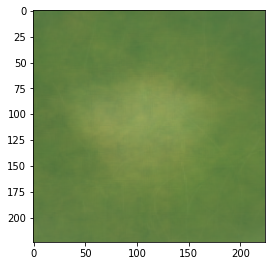

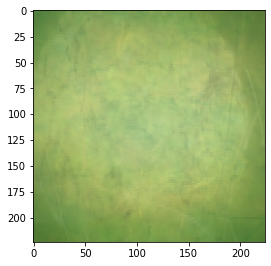

Texture Difference: 0.9112922353670001


In [52]:
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import warnings

warnings.filterwarnings("ignore")

i = 0
texture = []
for key in clusters.keys():
  fig = plt.figure(figsize=(40,40))    
  ax = fig.add_subplot(8, 8, i + 1)
  arr = get_similar(clusters.get(key))
  arr = choose_sim(list(arr),clusters.get(key),0.5)
  arr = sum(arr)/len(arr)
  img = np.asarray(torch.tensor(arr).permute(1,2,0).cpu().squeeze().detach().numpy() )
  filter_blurred_f = ndimage.gaussian_filter(img, 1)
  alpha = 1
  sharpened = img + alpha * (img - filter_blurred_f)
  ax.imshow(sharpened)
  texture.append(sharpened)

  i += 1
plt.show()

print("Texture Difference:",compare_texture(texture[0],texture[1]))


## Single Image High Resolution

In [47]:
!git clone https://github.com/krasserm/super-resolution.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 385, done.
remote: Total 385 (delta 0), reused 0 (delta 0), pack-reused 385
Receiving objects: 100% (385/385), 47.38 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (200/200), done.


In [48]:
!cp -r super-resolution/model/ /content/
!cp super-resolution/utils.py /content/

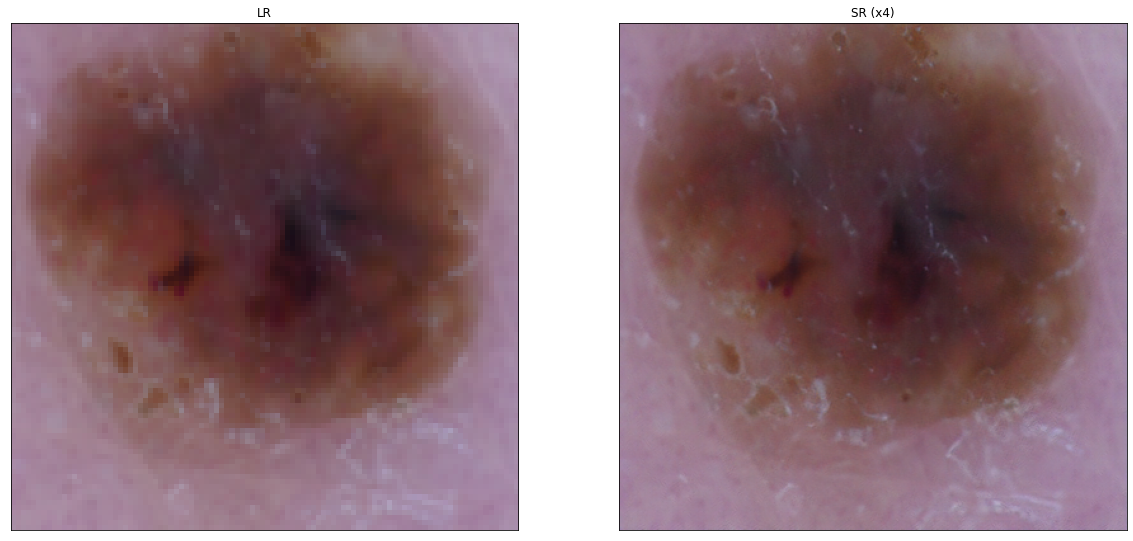

In [50]:
from model.srgan import generator
from utils import load_image, plot_sample
from model.common import resolve_single

model_hr = generator()
model_hr.load_weights('/content/drive/My Drive/Interpretability Experiments/srgan_weights/srgan/gan_generator.h5')

lr = load_image('img1.png')[:,:,:3]
sr = resolve_single(model_hr, lr)

plot_sample(lr, sr)
